### Import all the libraries.

In [1]:
import tensorflow as tf
import pathlib
import random
import IPython.display as display
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt


### Define all the functions.

In [40]:
def downloadUnzip(fileName, sourceURL, dest_dir):
    ''' 
        This function downloads the files from the source and unzips thems and stores them to a specified destination.
        
        Args:
            fileName(str): Name of file from source
            sourceURL(str): url of the source to download from
            dest_dir(str): Path on local to store the downloaded data
            
        Returns: Path of saved files on local to access
    '''
    
    data_root = tf.keras.utils.get_file(fileName, sourceURL, untar=True, cache_dir=dest_dir,extract=True)
    data_root = pathlib.Path(data_root)
    return data_root

def get_all_paths(data_root):
    ''' 
        This function allows us to get all image paths and randomly shuffles them.
        
        Args:
            data_root(str): root directory where data has been downloaded.
            
        Returns: Path all images
    '''
    all_image_paths = list(data_root.glob('*/*'))
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths)
    return all_image_paths

def get_path_and_label(data_root):
    ''' 
        This function helps us get the path and label of each image.
        
        Args:
            data_root(str): root directory where data has been downloaded.
            
        Returns: Path and label
    '''
    all_image_paths = get_all_paths(data_root)
    X = [p.rsplit('/', 2)[1] + '/' + p.rsplit('/', 1)[1] for p in all_image_paths]
    y = [p.rsplit('/', 1)[0].rsplit('/', 1)[1] for p in all_image_paths]
    return X, y

def caption_image(image_path):
    ''' 
        This function helps us caption each image. 
        
        Args:
            image_path(str): path of image to be captioned
            
        Returns: Path and caption
    '''
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return image_rel, str(image_rel).split('/')[0]

def display_image_and_caption(data_root):
    ''' 
        This function helps display the image. 
        
        Args:
            data_root(str): root directory where data has been downloaded.
    '''
    for n in range(3):
        all_image_paths = get_all_paths(data_root)
        image_path = random.choice(all_image_paths)
        display.display(display.Image(image_path))
        imPath, label = caption_image(image_path)
        print(label)
        print()

def split_data(data_root, test_size, valid_size):
    ''' 
        This function helps us split data into train, test and validation with ratio of 60:20:20

        Args:
            data_root(str): root directory where data has been downloaded.
            
        Returns: A list of list of all the paths for each set of dataset.
    '''
    X, y = get_path_and_label(data_root)
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, test_size=valid_size, stratify=y_train_temp, random_state=42)
    X_data = [X_train, X_test, X_valid]
    return X_data

def write_dataset_to_file(filenames, X_data, root_file):
    ''' 
        This function writes all the datasets (train, test, validation) to files in a location locally.

        Args:
            data_root(str): root directory where data has been downloaded.
            filenames(list): list filenames ['trainData', 'testData', 'validataionData']
    ''' 
    for d, l in zip(X_data, filenames):
        with open(root_file+l+'.txt', 'w') as f:
            for item in d:
                f.write("%s\n" % item)

def class_dictionary(data_root):
    ''' 
        This function make the class labels a dictionary as follows:
        {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
        
        Args:
            data_root(str): root directory where data has been downloaded.
    '''
    all_image_paths = get_all_paths(data_root)
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
    label_to_index = dict((name, index) for index,name in enumerate(label_names))
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in all_image_paths]
    return label_to_index

# The following functions can be used to convert a value to a type compatible
# with tf.Example.
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def image_example(image_string, label, filename):
    '''
        This function Create a dictionary with features that may be relevant.
        
        Args:
            image_string(bytes): image as bytes
            label(str): Label of image
            filename(str): filename of image
            
        Returns: Tfrecords 
    '''
    image_shape = tf.image.decode_jpeg(image_string).shape
    for lab, val in label_to_index.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if lab == label:
            label_no = val
    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label_num': _int64_feature(label_no),
        'image_raw': _bytes_feature(image_string),
        'filename' : _bytes_feature(str.encode(filename)),
        'label': _bytes_feature(str.encode(label)),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(data_dir, split_path, output_path):
    '''
        This function writes to tfrecords
        
        Args:
            data_dir(str): path of directory where images are
            split_path(str): path where split(train, test, validation) data path file is
            output_path(str): path of where to store the tfrecords
    '''
    with tf.io.TFRecordWriter(output_path) as writer:
        f = open(split_path, "r")
        for line in f:
            label = line.split('/')[0]
            image_string = open(data_dir+line.rstrip('\n'), 'rb').read()
            tf_example = image_example(image_string, label, line)
            writer.write(tf_example.SerializeToString())

def create_image_feature_description():
    '''
        This function create a dictionary describing the features.
    
        Returns: Dictionary of image feature descriptions
    '''
    image_feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'label_num': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'filename' : tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }
    return image_feature_description

def parse_fn(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    image_feature_description = create_image_feature_description()
    parsed = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_image(parsed["image_raw"])
    image = tf.reshape(image, (parsed['height'], parsed['width'], 3))
    image = tf.image.resize(image, (300, 300))
    image = image/255.
    return image, parsed["label_num"]

def make_dataset(datasetPath, shuffle_buffer_size, batch_size):
    '''
        This function makes dataset for each split data.
        
        Args:
            datasetPath(str): path of where tfrecords are saved
            shuffle_buffer_size(int): size of shuffle buffer
            batch_size(int): size of batch
        
        Returns: dataset
    '''
    dataset = tf.data.TFRecordDataset(datasetPath)
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.repeat()
    dataset = dataset.map(map_func=parse_fn)
    dataset = dataset.batch(batch_size=batch_size)
    return dataset

def create_logisticModel():
    '''
        This function creates model for logistic regression.
        
        Returns: Model
    '''
    model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), tf.keras.layers.Dense(5, activation=tf.nn.softmax)])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_FC2layerModel():
    '''
        This function creates model for fully connected neural network of two layers.
        
        Returns: Model
    '''
    model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), tf.keras.layers.Dense(512, activation=tf.nn.relu),tf.keras.layers.Dense(5, activation=tf.nn.softmax)])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_CNNModel():
    '''
        This function creates model for convolutional   neural network of two layers.
        
        Returns: Model
    '''
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_callbacks(log_dir, checkpoint_path):
    '''
        This function creates model for logistic regression.
        
        Args:
            log_dir(str): path of log directory 
            checkpoint_path(str): path where to store checkpoint.
    '''
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, verbose=1)
    return tensorboard_callback, cp_callback
    
def read_image(image_path):
    '''
        This function reads the image we want to predict the class.
        
        Args:
            image_path(str): path of image we want to predict the class for.
            
        Returns: image as tensor
    '''
    with tf.io.gfile.GFile(image_path, 'rb') as fopen:
        imge = fopen.read()
    imge = tf.image.decode_image(imge)
    return imge

def make_prediction(imge, model):
    '''
        This function makes the prediciton on the new image.
        
        Args:
            image_path(str): path of image we want to predict the class for.
            
        Returns: Class of image
    '''
    w,h,d = imge.numpy().shape
    image = tf.reshape(imge, (w, h, d))
    image = tf.image.resize(image, (300, 300))
    image = image/255.
    image = tf.expand_dims(image, 0)
    return model.predict_classes(image)

def predict_logisticModel(checkpoint_path, image_path, label_to_index):
    '''
        This function makes the preditction of class of image using logistic regression.
        
        Args:
            image_path(str): path of image we want to predict the class for.
            checkpoint_path(str): path where to store checkpoint.
            label_to_index(dict): dictionary of labels and their indices.
            
            
        Returns: Class of image
    '''
    model = create_logisticModel()
    model.load_weights(checkpoint_path)
    imge = read_image(image_path)
    prediction_class = make_prediction(imge, model)
    for name, lab in label_to_index.items():    
        if lab == prediction_class:
            return name, lab

def predict_FC2layerModel(checkpoint_path, image_path, label_to_index):
    '''
        This function makes the preditction of class of image using logistic regression.
        
        Args:
            image_path(str): path of image we want to predict the class for.
            checkpoint_path(str): path where to store checkpoint.
            label_to_index(dict): dictionary of labels and their indices.
            
            
        Returns: Class of image
    '''
    model = create_FC2layerModel()
    model.load_weights(checkpoint_path)
    imge = read_image(image_path)
    prediction_class = make_prediction(imge, model)
    for name, lab in label_to_index.items():    
        if lab == prediction_class:
            return name, lab

def predict_CNNModel(checkpoint_path, image_path, label_to_index):
    '''
        This function makes the preditction of class of image using logistic regression.
        
        Args:
            image_path(str): path of image we want to predict the class for.
            checkpoint_path(str): path where to store checkpoint.
            label_to_index(dict): dictionary of labels and their indices.
            
            
        Returns: Class of image
    '''
    model = create_CNNModel()
    model.load_weights(checkpoint_path)
    imge = read_image(image_path)
    prediction_class = make_prediction(imge, model)
    for name, lab in label_to_index.items():    
        if lab == prediction_class:
            return name, lab

### Download and unzip the data calling 'downloadUnzip( )'

In [41]:
fileName = 'flower_photos'
dest_dir = '/home/ubuntu/datasets'
sourceURL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_root = downloadUnzip(fileName, sourceURL, dest_dir)

### Display Image & Caption calling 'display_image_and_caption( )'

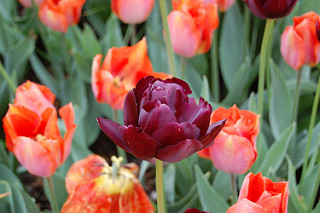

tulips



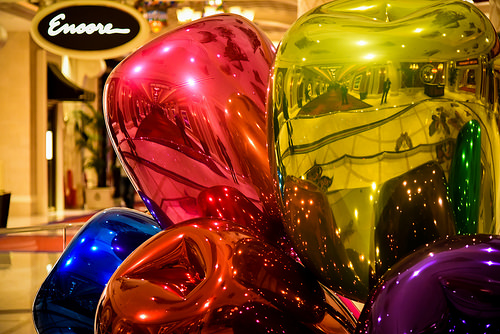

tulips



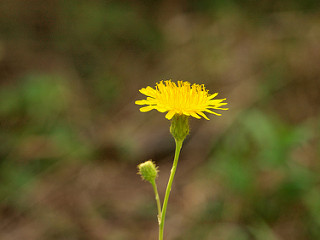

dandelion



In [42]:
display_image_and_caption(data_root)

### Split data into training, validation, testing by calling 'split_data()'

In [43]:
test_size = 0.20
valid_size = 0.20
X_data = split_data(data_root, test_size, valid_size)

### Make a dictionary of labels

In [44]:
label_to_index = class_dictionary(data_root)

### Write the split data (above function) into three different files by calling 'write_dataset_to_file()'

In [45]:
filenames = ['trainData', 'testData', 'validataionData']
root_file = ''
write_dataset_to_file(filenames, X_data, root_file)

### Write data into tfrecords by calling 'write_tfrecords()'
This can be called three different times, for each training, testing and validation sets.

In [46]:
data_dir = '/home/aakanksha/datasets/flower_photos/'
#split_path = ['trainData.txt', 'testData.txt', 'validataionData.txt']
#output_path = ['trainImages.tfrecords', 'validImages.tfrecords', 'testImages.tfrecords']
#write_tfrecords(data_dir, 'trainData.txt', 'trainImages.tfrecords') 
#write_tfrecords(data_dir, 'validataionData.txt', 'testImages.tfrecords') 
#write_tfrecords(data_dir, 'testData.txt', 'validImages.tfrecords') 


### Dataset for each training, testing and validation are made with a specified batch size and shuffle buffer size by calling 'make_dataset()' three times

In [47]:
shuffle_buffer_size = 32
batch_size = 32
ds_train = make_dataset('trainImages.tfrecords', shuffle_buffer_size, batch_size)
ds_valid = make_dataset('validImages.tfrecords', shuffle_buffer_size, batch_size)
ds_test = make_dataset('testImages.tfrecords', shuffle_buffer_size, batch_size)

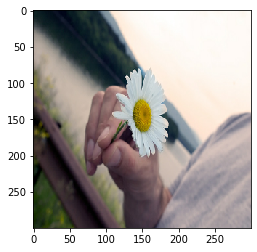

0


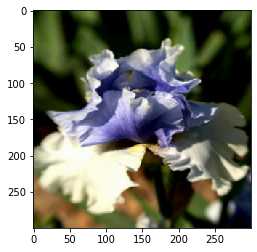

4


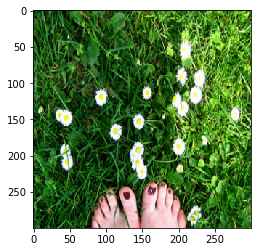

0


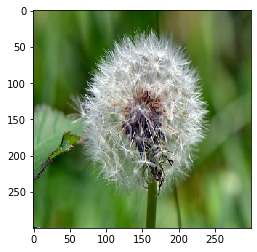

1


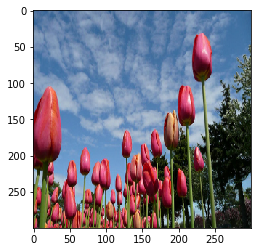

4


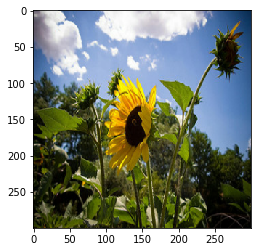

3


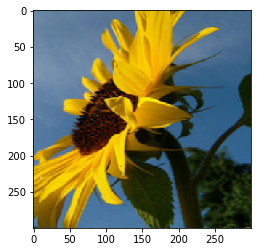

3


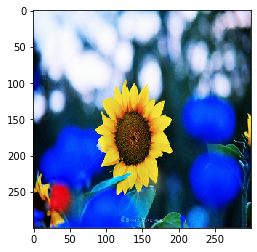

3


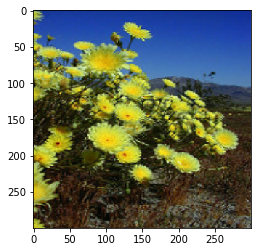

1


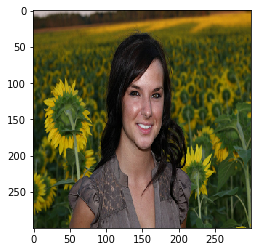

3


In [48]:
for images, labels in ds_train.take(10):
    image = images.numpy()[0, :, :, :]
    label = labels.numpy()[0]
    plt.imshow(image, interpolation='nearest')
    plt.show()
    #print(image)
    
    print(label)

### The 'create_callback()' function is called to create two callbacks (one for tensorboard and the other for creating a checkpoint for storing the model. 
### Model is made by using logistic regression, by calling 'create_logisticModel()'
### Then the model is fit using training data and validation data

In [49]:
num_train = len(X_data[0])
num_test = len(X_data[1])
num_val = len(X_data[2])
tr_steps_per_epoch = num_train//batch_size
val_steps_per_epoch = num_val//batch_size
te_steps_per_epoch = num_test//batch_size

In [50]:
log_dir="summaries"
checkpoint_path = "training_3/cp.ckpt"
tensorboard_callback, cp_callback = create_callbacks(log_dir, checkpoint_path)
logistic_model = create_logisticModel()
logistic_history = logistic_model.fit(ds_train, epochs=5, steps_per_epoch=tr_steps_per_epoch, validation_steps=val_steps_per_epoch, validation_data=ds_valid,callbacks=[tensorboard_callback, cp_callback])

Epoch 1/5
72/73 [============================>.] - ETA: 0s - loss: 12.1092 - accuracy: 0.2290
Epoch 00001: val_loss improved from inf to 12.03261, saving model to training_3/cp.ckpt
73/73 [==============================] - 11s 150ms/step - loss: 12.0951 - accuracy: 0.2293 - val_loss: 12.0326 - val_accuracy: 0.2535
Epoch 2/5
72/73 [============================>.] - ETA: 0s - loss: 12.1655 - accuracy: 0.2557
Epoch 00002: val_loss did not improve from 12.03261
73/73 [==============================] - 11s 157ms/step - loss: 12.1783 - accuracy: 0.2554 - val_loss: 12.0326 - val_accuracy: 0.2535
Epoch 3/5
72/73 [============================>.] - ETA: 0s - loss: 12.1445 - accuracy: 0.2570
Epoch 00003: val_loss did not improve from 12.03261
73/73 [==============================] - 10s 131ms/step - loss: 12.1507 - accuracy: 0.2567 - val_loss: 12.0326 - val_accuracy: 0.2535
Epoch 4/5
72/73 [============================>.] - ETA: 0s - loss: 12.1725 - accuracy: 0.2507
Epoch 00004: val_loss did not 

### Plot loss and accuracy

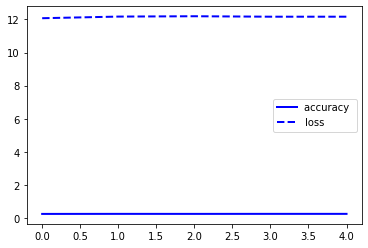

In [12]:
log_acc = logistic_history.history['accuracy']
log_loss = logistic_history.history['loss']

plt.plot(log_acc , marker='', color='blue', linewidth=2, label='accuracy ')
plt.plot(log_loss, marker='', color='blue', linewidth=2, linestyle='dashed', label='loss')
plt.legend()


#### Summary of model is diplayed.

In [13]:
logistic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1350005   
Total params: 1,350,005
Trainable params: 1,350,005
Non-trainable params: 0
_________________________________________________________________


### Model is evaluated using the test dataset.

In [14]:
results = logistic_model.evaluate(ds_test, steps=te_steps_per_epoch)
print(results)

22/22 [==============================] - 2s 104ms/step - loss: 11.9970 - accuracy: 0.2557
[11.996991417624734, 0.2556818]


### A prediction is made on a new image, using the function 'predict_logisticModel()'

In [15]:
predict_image_path = '/home/aakanksha/datasets/flower_photos/daisy/15207766_fc2f1d692c_n.jpg'
name, label_id = predict_logisticModel(checkpoint_path ,predict_image_path, label_to_index)
print(name, label_id)

dandelion 1


### The 'create_callback()' function is called to create two callbacks (one for tensorboard and the other for creating a checkpoint for storing the model.

### Model is made by using lfully connected neural network, by calling 'create_FC2layerModel()'

### Then the model is fit using training data and validation data

In [ ]:
log_dir="summaries_fc2layer"
checkpoint_path = "training_4/cp.ckpt"
tensorboard_callback, cp_callback = create_callbacks(log_dir, checkpoint_path)
fc_model = create_FC2layerModel()
fc_history = fc_model.fit(ds_train, epochs=5,steps_per_epoch=tr_steps_per_epoch, validation_steps=val_steps_per_epoch, validation_data=ds_valid,callbacks=[tensorboard_callback, cp_callback])

Epoch 1/5


W0709 13:11:28.715443 140060108257088 deprecation.py:323] From /home/aakanksha/venv/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


72/73 [============================>.] - ETA: 0s - loss: 12.4772 - accuracy: 0.2052

### Plot loss and accuracy

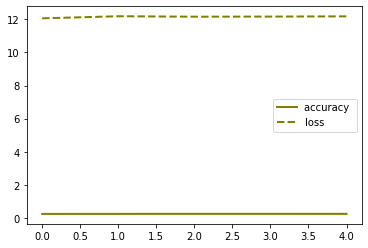

In [12]:
acc = fc_history.history['accuracy']
loss = fc_history.history['loss']

plt.plot( acc , marker='', color='olive', linewidth=2, label='accuracy ')
plt.plot(loss, marker='', color='olive', linewidth=2, linestyle='dashed', label='loss')
plt.legend()

#### Summary of model is diplayed.

In [13]:
fc_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  138240512 
_________________________________________________________________
dense_4 (Dense)              multiple                  131328    
_________________________________________________________________
dense_5 (Dense)              multiple                  1285      
Total params: 138,373,125
Trainable params: 138,373,125
Non-trainable params: 0
_________________________________________________________________


### Model is evaluated using the test dataset.

In [14]:
fc_results = fc_model.evaluate(ds_test, steps=te_steps_per_epoch)
print(fc_results)

22/22 [==============================] - 3s 149ms/step - loss: 12.0199 - accuracy: 0.2543
[12.019886493682861, 0.25426137]


### A prediction is made on a new image, using the function 'predict_FC2layerModel()'

In [15]:
predict_image_path = '/home/aakanksha/datasets/flower_photos/daisy/15207766_fc2f1d692c_n.jpg'
name, label_id = predict_FC2layerModel(checkpoint_path ,predict_image_path, label_to_index)
print(name, label_id)

dandelion 1


### The 'create_callback()' function is called to create two callbacks (one for tensorboard and the other for creating a checkpoint for storing the model.

### Model is made by using lfully connected neural network, by calling 'create_CNNlayerModel()'

### Then the model is fit using training data and validation data 

In [11]:
log_dir="summaries_CNNlayer"
checkpoint_path = "training_5/cp.ckpt"
tensorboard_callback, cp_callback = create_callbacks(log_dir, checkpoint_path)
cnn_model = create_CNNModel()
cnn_history = cnn_model.fit(ds_train, epochs=5,steps_per_epoch=tr_steps_per_epoch, validation_steps=val_steps_per_epoch, validation_data=ds_valid,callbacks=[tensorboard_callback, cp_callback])

W0709 13:36:04.277717 139827433994048 deprecation.py:323] From /home/aakanksha/venv/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
72/73 [============================>.] - ETA: 1s - loss: 12.0688 - accuracy: 0.2413
Epoch 00001: val_loss improved from inf to 12.22849, saving model to training_5/cp.ckpt
73/73 [==============================] - 142s 2s/step - loss: 12.0553 - accuracy: 0.2423 - val_loss: 12.2285 - val_accuracy: 0.2413
Epoch 2/5
72/73 [============================>.] - ETA: 1s - loss: 12.1725 - accuracy: 0.2448
Epoch 00002: val_loss did not improve from 12.22849
73/73 [==============================] - 142s 2s/step - loss: 12.1507 - accuracy: 0.2461 - val_loss: 12.2285 - val_accuracy: 0.2413
Epoch 3/5
72/73 [============================>.] - ETA: 1s - loss: 12.1865 - accuracy: 0.2439
Epoch 00003: val_loss did not improve from 12.22849
73/73 [==============================] - 142s 2s/step - loss: 12.1990 - accuracy: 0.2432 - val_loss: 12.2285 - val_accuracy: 0.2413
Epoch 4/5
72/73 [============================>.] - ETA: 1s - loss: 12.1515 - accuracy: 0.2461
Epoch 00004: val_loss did not improv

### Plot loss and accuracy

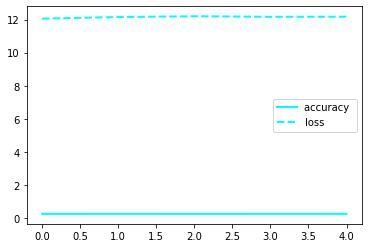

In [12]:
acc = cnn_history.history['accuracy']
loss = cnn_history.history['loss']

plt.plot( acc , marker='', color='cyan', linewidth=2, label='accuracy ')
plt.plot(loss, marker='', color='cyan', linewidth=2, linestyle='dashed', label='loss')
plt.legend()

#### Summary of model is diplayed.

In [13]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 322624)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

### Model is evaluated using the test dataset.

In [14]:
cnn_results = cnn_model.evaluate(ds_test, steps=te_steps_per_epoch)
print(cnn_results)

22/22 [==============================] - 9s 404ms/step - loss: 12.0199 - accuracy: 0.2543
[12.019886363636363, 0.25426137]


### A prediction is made on a new image, using the function 'predict_CNNlayerModel()'

In [15]:
predict_image_path = '/home/aakanksha/datasets/flower_photos/daisy/15207766_fc2f1d692c_n.jpg'
name, label_id = predict_CNNModel(checkpoint_path ,predict_image_path, label_to_index)
print(name, label_id)

dandelion 1
